# Network Web Analysis in English Articles

## 1. Module Import

In [44]:
# self defined Modules
from myModules.utils.data.DataLoader import DataLoader
from myModules.utils.merge.mergeOverPeriod import merge
from myModules.preprocess import cleaning, removeStopWords_ST, tagging, extract_some_pos_ST

# General Modules
import pandas as pd
import numpy as np
import warnings
from tqdm.notebook import tqdm
import operator
import re
import glob

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
%matplotlib inline

## 2. Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_ST/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_ST/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_ST/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/ST/'
RESULT_2 = RESULT_ROOT + '/2시기/ST/'
RESULT_3 = RESULT_ROOT + '/3시기/ST/'

In [3]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1, mode='ST')
texts_2 = DataLoader(files_2, mode='ST')
texts_3 = DataLoader(files_3, mode='ST')

## 3. PreProcess

### 3-1. Data Cleaning

In [4]:
cleaned_1 = cleaning(texts_1, mode='ST')
cleaned_2 = cleaning(texts_2, mode='ST')
cleaned_3 = cleaning(texts_3, mode='ST')

### 3-2. Tokenizing

In [5]:
def test_apostrophe(data):
    result = []

    for tokenized in data:
        for token in tokenized:
            if "'" in token: result.append(token)

    set_apos = set(result)

    print(f"Apostrophe 를 가진 token : \n{set_apos}")

def test_dot(data):
    result = []

    for tokenized in data:
        for token in tokenized:
            if '.' in token : result.append(token)
    
    set_dot = set(result)

    print(f"Dot 을 가진 token : \n{set_dot}")

def remove_apostrophe(data, exception):
    result = []

    for tokenized in data:
        tokens = []
        for token in tokenized:
            if token not in exception:
                tokens.append(re.sub("[^a-z\.]", "", token))
            else : tokens.append(token)
        result.append(tokens)
    
    return result

def remove_dot(data, exception):
    result = []

    for tokenized in data:
        tokens = []
        for token in tokenized:
            if token not in exception:
                tokens.append(re.sub("[^a-z']", "", token))
            else : tokens.append(token)
        result.append(tokens)
    
    return result

def remove_special(data, exception):
    not_alnum = []
    result = []

    for tokens in data:
        for token in tokens:
            if not token.isalnum() : not_alnum.append(token)
    
    remove_list = set(not_alnum)
    exception = set(exception)
    remove_list = remove_list.difference(exception)
    print(f"Removed : {remove_list}")

    for article in data:
        tokens = []
        for token in article:
            if token not in remove_list:
                tokens.append(token)
        result.append(tokens)
    
    return result

In [6]:
tokenized_1 = [word_tokenize(text) for text in cleaned_1]
tokenized_2 = [word_tokenize(text) for text in cleaned_2]
tokenized_3 = [word_tokenize(text) for text in cleaned_3]

#### Period 1

In [7]:
test_apostrophe(tokenized_1)

Apostrophe 를 가진 token : 
{"'d", "'structure", "'are", "'", "'ll", "'blamed", "'madam", "'german", "o'clock", "'into", "'heat", "'liberty", "n't", "'m", "'system", "'mvd", "'democracy", "'ve", "'s"}


In [8]:
test_dot(tokenized_1)

Dot 을 가진 token : 
{'n.', 's.', 'u.s.', 'mrs.', 'm.', 'p.', 'a.m.', 'jr.', '...', 'oct.', 'mr.', 'camps.if', 'u.n.', 'i.', 'gen.', 'co.', 'ph.d.', '.', 'u.', 'a.', 't.', 'st.', 'e.', 'dr.', 'f.', '..', 'col.', 'p.m.', 'w.', 'u.s.s.r.', 'messrs.', 'frightened.to', 'v.'}


##### `apostrophe` 처리

- "'ll", "'d", "'s", "'ve", "n't", "o'clock" 외에는 제거

In [9]:
exception = ["'ll", "'d", "'s", "'ve", "n't", "o'clock"]

tokenized_1_ = remove_apostrophe(tokenized_1, exception)

In [10]:
test_apostrophe(tokenized_1_)

Apostrophe 를 가진 token : 
{"'d", "'ll", "n't", "o'clock", "'ve", "'s"}


##### `dot` 처리

In [11]:
exception = ['mrs.', 'u.s.', 'ph.d.', 'a.m.', 'p.m.', 'u.n.', 'messrs.', 'u.s.s.r.', 'st.', 'mr.', 'jr.']

tokenized_1_ = remove_dot(tokenized_1_, exception)

In [12]:
test_dot(tokenized_1_)

Dot 을 가진 token : 
{'u.s.s.r.', 'u.s.', 'mrs.', 'mr.', 'messrs.', 'u.n.', 'st.', 'a.m.', 'jr.', 'ph.d.', 'p.m.'}


In [13]:
exception = ["'ll", "'d", "'s", "'ve", "n't", "o'clock", 'mrs.', 'u.s.', 'ph.d.', 'a.m.', 'p.m.', 'u.n.', 'messrs.', 'u.s.s.r.', 'st.', 'mr.', 'jr.']

tokenized_1_ = remove_special(tokenized_1_, exception)

Removed : {''}


### Peiod 2

In [14]:
test_apostrophe(tokenized_2)

Apostrophe 를 가진 token : 
{"'m", "'", "n't", "'for", "'s", "'reprisals"}


In [15]:
test_dot(tokenized_2)

Dot 을 가진 token : 
{'n.', 's.', 'tyranny.the', 'm.', 'p.', 'b.', 'mr.', 'i.', 'gen.', '.', 'u.s.a.', 'a.', 'l.', 't.', 'e.', 'dr.', '..', 'p.m.', 'w.', 'u.s.s.r.', 'h.', 'g.', 'messrs.', 'r.', 'c.', 'o.', 'v.'}


##### `apostrophe` 처리

In [16]:
exception = ["'s", "n't"]

tokenized_2_ = remove_apostrophe(tokenized_2, exception)

In [17]:
test_apostrophe(tokenized_2_)

Apostrophe 를 가진 token : 
{"'s", "n't"}


##### `dot` 처리

In [18]:
exception = ["mr.", "u.s.a.", "dr.", "p.m.", "u.s.s.r.", "messrs."]

tokenized_2_ = remove_dot(tokenized_2_, exception)

In [19]:
test_dot(tokenized_2_)

Dot 을 가진 token : 
{'u.s.s.r.', 'messrs.', 'mr.', 'dr.', 'p.m.', 'u.s.a.'}


In [20]:
exception = ["'s", "n't", "mr.", "u.s.a.", "dr.", "p.m.", "u.s.s.r.", "messrs."]

tokenized_2_ = remove_special(tokenized_2_, exception)

Removed : {''}


### Period 3

In [21]:
test_apostrophe(tokenized_3)

Apostrophe 를 가진 token : 
{"'d", "'has", "'vas", "'spontaneous", "'", "'ll", "n't", "o'clock", "'ve", "'s", "'recession"}


In [22]:
test_dot(tokenized_3)

Dot 을 가진 token : 
{'n.', 's.', 'u.n.r.r.a', 'mrs.', 'm.', 'd.', 'p.', 'a.m.', 'b.', 'jr.', '...', '..................', 'mr.', 'maj.', 'i.', 'gen.', '.', 's.s.r', 'u.', 'a.', 'l.', 't.', 'st.', 'e.', 'dr.', 'j.', 'f.', 'col.', 'p.m.', 'w.', 'u.s.s.r.', 'h.', 'g.', 'r.', 'c.', 'o.', 'v.', 'prof.'}


##### `apostrophe` 처리

In [23]:
exception = ["'ll", "n't", "o'clock", "'ve", "'s"]

tokenized_3_ = remove_apostrophe(tokenized_3, exception)

In [24]:
test_apostrophe(tokenized_3_)

Apostrophe 를 가진 token : 
{"'ll", "n't", "o'clock", "'ve", "'s"}


##### `dot` 처리

In [25]:
exception = ["u.n.r.r.a", "mrs.", "a.m.", "jr.", "mr.", "maj.", "s.s.r", "st.", "dr.", "p.m.", "u.s.s.r.", "prof."]

tokenized_3_ = remove_dot(tokenized_3_, exception)

In [26]:
test_dot(tokenized_3_)

Dot 을 가진 token : 
{'u.s.s.r.', 'u.n.r.r.a', 'mrs.', 'mr.', 'maj.', 'st.', 'a.m.', 'dr.', 'jr.', 'prof.', 's.s.r', 'p.m.'}


In [27]:
exception = ["u.n.r.r.a", "mrs.", "a.m.", "jr.", "mr.", "maj.", "s.s.r", "st.", "dr.", "p.m.", "u.s.s.r.", "prof.",\
    "'ll", "n't", "o'clock", "'ve", "'s"]

tokenized_3_ = remove_special(tokenized_3_, exception)

Removed : {''}


### 3-3. Remove Stopwords

In [49]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['would', 'could', 'might', 'need', 'can', 'must', \
    'e', 'one', 'two', 'upon', 'may', 'perhaps', 'living', 'seem', 'also', 'ii', 'ofthe',
    'also', 'much', 'therefore', 'u', 's']

wo_stopword_1 = removeStopWords_ST(tokenized_1_, stopwords, new_stopwords)
wo_stopword_2 = removeStopWords_ST(tokenized_2_, stopwords, new_stopwords)
wo_stopword_3 = removeStopWords_ST(tokenized_3_, stopwords, new_stopwords)

### 3-4. Lemmatization

In [50]:
def lemmatizing(data, lemmatizer):
    result = []

    for article in data:
        result.append([lemmatizer.lemmatize(token) for token in article])
    
    return result

In [51]:
lemmatizer = WordNetLemmatizer()

lemmatized_1 = lemmatizing(wo_stopword_1, lemmatizer)
lemmatized_2 = lemmatizing(wo_stopword_2, lemmatizer)
lemmatized_3 = lemmatizing(wo_stopword_3, lemmatizer)

### 3-5. Tagging

In [52]:
tagList = [['noun', ['NN','NNS','NNP','NNPS'], ['NNG','NNB','NNP','NNM']], \
    ['pronoun', ['PRP','WP','PRP'], ['NP']],
    ['verb', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], ['VV', 'VXV', 'VCP']],
    ['adjective', ['JJ', 'JJR', 'JJS'], ['VA', 'VXA', 'VCN']],
    ['adverb', ['RB', 'RBR', 'RBS', 'WRB', 'EX', 'RP'], ['MAG']],
    ['prep&conj', ['TO', 'IN', 'CC'], ['MAC']],
    ['determiner', ['DT', 'PDT', 'WDT'], ['MDT', 'MDN']],
    ['interjection',['UH'], ['IC']],
    ['number', ['CD'], ['NR', 'ON']],
    ['foreignW', ['FW'],['OL']],
    ['modal',['MD'],[]],
    ['josa', [], ['JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX']],
    ['possesiveS', ['POS'], []],
    ['others',['LS'], ['EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD', 'XPN', 'XPV', 'XSN', 'XSV', 'XSA', 'XR', 'UN', 'OH']]]

tagList = pd.DataFrame(tagList)
tagList.columns = ['POS', 'Eng_tag', 'Kor_tag']

In [53]:
tagged_1 = tagging(lemmatized_1, mode='ST')
tagged_2 = tagging(lemmatized_2, mode='ST')
tagged_3 = tagging(lemmatized_3, mode='ST')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [54]:
extracted_1 = extract_some_pos_ST(articles=tagged_1, tagList=tagList, pos_list=['noun', 'verb', 'adjective'])
extracted_2 = extract_some_pos_ST(articles=tagged_2, tagList=tagList, pos_list=['noun', 'verb', 'adjective'])
extracted_3 = extract_some_pos_ST(articles=tagged_3, tagList=tagList, pos_list=['noun', 'verb', 'adjective'])

## 4. Network Web Analysis

1. (시도 1) apriori를 이용하여 Token간 연관성 계산
    - 연관성 계산에 너무 많은 시간이 걸림.
2. (시도 2) 직접 동시출현빈도를 계산


In [31]:
class vocaDict:
    def __init__(self):
        self.word2id = {}
        self.id2word = []
        self.count = {}
    
    def getIdOrAdd(self, word):
        if word in self.word2id:
            return self.word2id[word]
        self.word2id[word] = len(self.word2id)
        self.id2word.append(word)
        return len(self.word2id) - 1
    
    def getWord(self, id):
        return self.id2word[id]
    
    def calcWordPairFreq(self, text):
        wordIds = [self.getIdOrAdd(word) for word in text]
        for idx, a in enumerate(tqdm(wordIds, desc="Word Pair Frequency ")):
            for b in wordIds[idx+1:]:
                if a == b: continue
                if a > b: a, b = b, a
                self.count[a, b] = self.count.get((a, b), 0) + 1
        return self.count
    
    def to_csv(self, root='./'):
        df = []
        for key, val in self.count.items():
            df.append([self.getWord(key[0]), self.getWord(key[1]), val])
        df = pd.DataFrame(df, columns=['word1', 'word2', 'freq'])
        df = df.sort_values(by=['freq'], ascending=False)
        df = df.reset_index(drop=True)

        df.to_csv(root+'word-pair-freq.csv', index=False)

class Network:
    def calc_properties(self, edge_num, data):
        self.edge_num = edge_num
        self.data = data
        self.max_freq = -1
        self.quartile = 0

        G_centrality = nx.Graph()

        for idx in range(self.edge_num):
            G_centrality.add_edge(self.data['word1'][idx], self.data['word2'][idx], weight=int(self.data['freq'][idx]))
            if self.max_freq < int(self.data['freq'][idx]): self.max_freq = int(self.data['freq'][idx])
        
        self.quartile = self.max_freq / 4
        
        self.dgr = nx.degree_centrality(G_centrality)
        self.pgr = nx.pagerank(G_centrality)

        self.dgr = sorted(self.dgr.items(), key=operator.itemgetter(1), reverse=True)
        self.pgr = sorted(self.pgr.items(), key=operator.itemgetter(1), reverse=True)
    
    def plot(self, title='Network Web Analysis', root='./'):
        G = nx.Graph()

        # node 추가
        for idx in range(len(self.pgr)):
            G.add_node(self.pgr[idx][0], weight=self.dgr[idx][1])
        
        # edge 추가
        for idx in range(self.edge_num):
            G.add_edge(self.data['word1'][idx], self.data['word2'][idx], weight=int(self.data['freq'][idx]))
        
        # 토폴로지 형태 정의
        # pos = graphviz_layout(G, prog='neato')
        pos = graphviz_layout(G, prog='twopi')

        # Network 시각화
        fig = plt.figure(figsize=(30, 20))
        plt.margins(x=0.1, y=0.2)
        ax = fig.gca()

        # figure에 node 그리기
        Blues_modified = cm.get_cmap('Blues', 256)
        newcmp = ListedColormap(Blues_modified(np.linspace(0.2, 0.8, 4)))
        nc = nx.draw_networkx_nodes(G, pos, node_size=[node[1]['weight']*20000 for node in G.nodes(data=True)], \
            node_color=[node[1]['weight'] for node in G.nodes(data=True)], cmap=newcmp,
            node_shape='o', alpha=0.9, linewidths=0.4, edgecolors='#000000')

        # figure에 label 그리기
        nx.draw_networkx_labels(G, pos=pos, font_size=16, alpha=0.7, font_color='black', font_weight='bold')

        # figure에 edge 그리기
        Greys_modified = cm.get_cmap('Greys', 256)
        newcmp = ListedColormap(Greys_modified(np.linspace(0.2, 1.0, 4)))
        ec = nx.draw_networkx_edges(G, pos, edge_color=[edge[2]['weight'] for edge in G.edges(data=True)], \
            edge_cmap=newcmp, style='solid', width=2, connectionstyle='arc3,rad=-0.3')
        
        # title 지정
        plt.title(title, fontsize=25)
        # axis 선 안보이게 설정
        plt.axis('off')

        # color bar 추가
        axins = inset_axes(ax,\
            width='1%',
            height='30%',
            loc='center right',
            borderpad=0)
        cbar = plt.colorbar(nc, cax=axins)
        cbar.ax.set_ylabel('Centrality', rotation=270, fontsize=12, labelpad=15)

        axins = inset_axes(ax, \
            width='1%',
            height='30%',
            loc='center left',
            borderpad=0)
        cbar = plt.colorbar(ec, cax=axins)
        cbar.ax.set_ylabel('Word Pair Freqency', rotation=270, fontsize=12, labelpad=15)

        # figure 저장
        plt.savefig(root+'network-web-analysis.png')
        # figure 출력
        plt.show()

### Period 1

In [55]:
# 최초 1회의 한하여 실행

voca = vocaDict()

result = voca.calcWordPairFreq(merge(extracted_1))

voca.to_csv(root=RESULT_1)

Word Pair Frequency :   0%|          | 0/28509 [00:00<?, ?it/s]

In [56]:
df = pd.read_csv(RESULT_1+'word-pair-freq.csv')

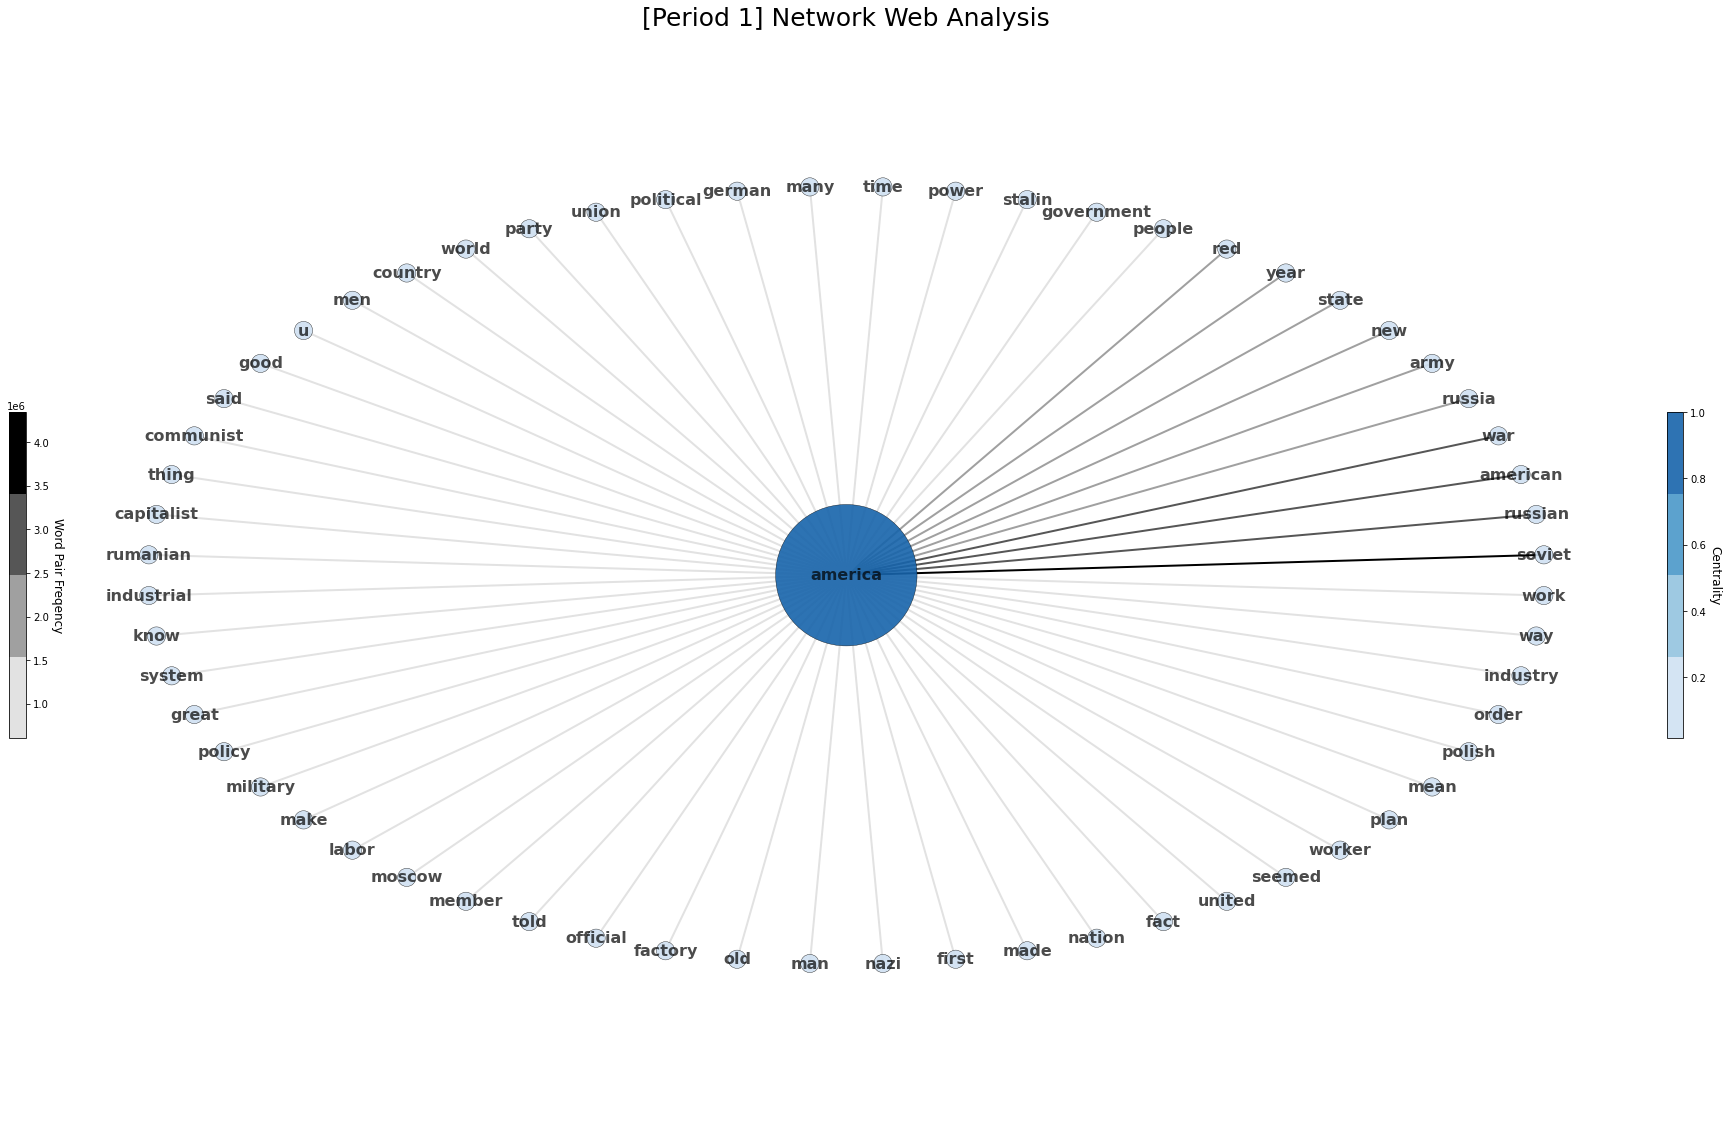

In [59]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=60, data=df)

# Network 시각화
net.plot(title='[Period 1] Network Web Analysis', root=RESULT_1)

### Period 2

In [ ]:
# 최초 1회의 한하여 실행

voca = vocaDict()

result = voca.calcWordPairFreq(merge(wo_stopword_2))

voca.to_csv(root=RESULT_2)

In [ ]:
df = pd.read_csv(RESULT_2+'word-pair-freq.csv')

In [ ]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=40, data=df)

# Network 시각화
net.plot(title='[Period 2] Network Web Analysis', root=RESULT_2)

### Period 3

In [ ]:
# 최초 1회의 한하여 실행
voca = vocaDict()

result = voca.calcWordPairFreq(merge(wo_stopword_3))

voca.to_csv(root=RESULT_3)

In [ ]:
df = pd.read_csv(RESULT_3 + 'word-pair-freq.csv')

In [ ]:
net = Network()

net.calc_properties(edge_num=40, data=df)

net.plot(title='[Period 3] Network Web Analysis', root='./')